# Evaluation Curve For ML

Reference:
* [sklearn PR curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)
* [机器学习之类别不平衡问题 (2) —— ROC和PR曲线](https://zhuanlan.zhihu.com/p/34655990)
* Implementation Reference - https://github.com/massquantity/Class-Imbalance

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data

In [2]:
X, y = make_classification(n_samples=2000, n_features=10, n_informative=4, n_redundant=1, n_classes=2,
                          n_clusters_per_class=1, weights=[0.9,0.1], flip_y=0.1, random_state=2018)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
X_pca.columns=["pca_a","pca_b"]
X_pca["y"] = y

Text(11.335,0.5,'axis_2')

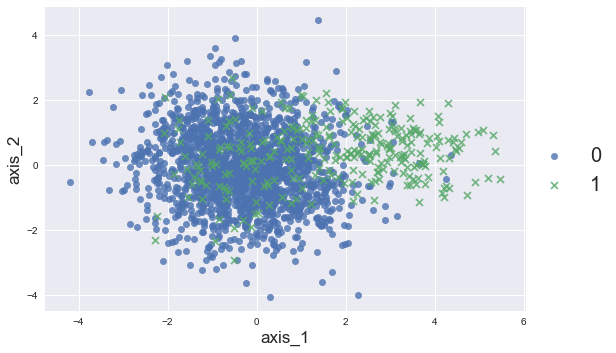

In [5]:
sns.set()
sns.lmplot("pca_a", "pca_b", data=X_pca, hue="y", fit_reg=False, markers=["o", "x"], size=5, aspect=1.5, legend=False)
plt.legend(fontsize=20,bbox_to_anchor=(0.98, 0.6),edgecolor ='r')   
plt.xlabel("axis_1",fontsize=17)
plt.ylabel("axis_2",fontsize=17)

## 2. AUC (Area Under the Curve)

Make 10-Dimension Data to 2-Dimension via PCA and plot the distribution.
$$TPR = \frac{TP}{P}$$
$$FPR = \frac{FP}{P}$$
<img src="images/AUC.jpg" alt="drawing" style="width:350px;"/>

In [ ]:
def get_roc(pos_prob, y_true):
    pos = y_true[y_true==1]
    neg = y_true[y_true==0]
    # 按概率大小逆序排列
    threshold = np.sort(pos_prob)[::-1]        
    y = y_true[pos_prob.argsort()[::-1]]
    tpr_all = [0] ; fpr_all = [0]
    tpr = 0 ; fpr = 0
    x_step = 1/float(len(neg))
    y_step = 1/float(len(pos))
    y_sum = 0                                  
    # 用于计算AUC
    for i in range(len(threshold)):
        if y[i] == 1:
            tpr += y_step
            tpr_all.append(tpr)
            fpr_all.append(fpr)
        else:
            fpr += x_step
            fpr_all.append(fpr)
            tpr_all.append(tpr)
            y_sum += tpr
    # 获得总体TPR，FPR和相应的AUC
    return tpr_all,fpr_all,y_sum*x_step         